In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import os
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colormaps
import PIL
import cv2
import torch.nn.functional as F
import pandas as pd
import scipy.stats as stats

In [48]:
class AgeDataset(Dataset):
    def __init__(self, root_dir, age_sheet_path, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]
        self.transform = transform
        self.df = pd.read_excel(age_sheet_path)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.root_dir, img_name)

        img_id = '_'.join(img_name.split('_')[:3])
        img_age = df.loc[df['ID']==img_id, 'Age'].values[0]

        # Load image
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(img_age, dtype=torch.float32)

In [49]:
# df containing age assignments
df = pd.read_excel('/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx')
#df

age_sheet_path = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/oasis_cross-sectional-5708aa0a98d82080.xlsx'

In [50]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets
train_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/train', 
                           age_sheet_path=age_sheet_path, transform=transform)
test_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/test', 
                          age_sheet_path=age_sheet_path, transform=transform)
val_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/val', 
                         age_sheet_path=age_sheet_path, transform=transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# very mild demented
vmd_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/VeryMildDemented/VeryMildDemented',
                         age_sheet_path=age_sheet_path, transform=transform)
vmd_loader = DataLoader(vmd_dataset, batch_size=32, shuffle=False)

# mild demented
md_dataset = AgeDataset(root_dir='/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/MildDemented/MildDemented',
                         age_sheet_path=age_sheet_path, transform=transform)
md_loader = DataLoader(md_dataset, batch_size=32, shuffle=False)

In [51]:
# confirm filename format to extract age
for img, age in train_loader:
    print(img.shape, age)
    break

torch.Size([32, 1, 224, 224]) tensor([21., 20., 21., 85., 23., 22., 48., 21., 19., 57., 69., 68., 22., 19.,
        23., 72., 23., 90., 68., 20., 22., 21., 57., 38., 23., 51., 23., 20.,
        20., 71., 63., 54.])


In [52]:
# unedited model
model = models.efficientnet_b0(weights=None)
#model

In [74]:
def setup_model():
    model = models.efficientnet_b0(weights=None)

    # grayscale input
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    
    # regression output
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 1, bias=True)
    # increase dropout to combat overfitting
    model.classifier[0] = nn.Dropout(p=0.5, inplace=True)

    return model

def train(model, train_loader, val_loader, num_epochs=10, lr=1e-4, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    print(f"Using {device}")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4) # *** TRYING WEIGHT DECAY TO COMBAT OVERFITTING ***

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
            inputs, targets = inputs.to(device), targets.to(device)

            # forward
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs.view(-1), targets)  # flatten for regression
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print training statistics
        avg_train_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss}')
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for batch_idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.view(-1), targets)
                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'run2_effnetb0_alz_saved_states/effnetb0_alz_ep{epoch+1}.pth')
            print(f'saved model at {best_val_loss} loss')

        val_losses.append(avg_val_loss)

    print("Done")
    return train_losses, val_losses

def evaluate(model, test_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    model.to(device)
    
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            true_labels.append(targets.cpu().numpy())

    predictions = np.concatenate(predictions, axis=0).flatten()
    true_labels = np.concatenate(true_labels, axis=0).flatten()

    # Compute evaluation metrics
    mae = mean_absolute_error(true_labels, predictions)
    mse = mean_squared_error(true_labels, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_labels, predictions)

    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'R2 Score: {r2}')

    return true_labels, predictions

def plot_scatter(true_labels, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(true_labels, predictions, alpha=0.5)
    plt.xlabel('True Age')
    plt.ylabel('Predicted Age')
    plt.axline((0,0),(80,80), label = 'Perfect Match', color='r')
    plt.legend()
    plt.title('Predicted Age vs True Age')
    plt.show()

def plot_error_distribution(true_labels, predictions):
    errors = predictions - true_labels
    mean = np.mean(errors)
    std = stats.sem(errors)
    lower = mean - 2 * std
    upper = mean + 2*std
    plt.hist(errors, bins=1000, density=True)
    plt.axvline(mean, color = 'r', label=f'Mean: {mean:.2f}')
    plt.axvline(lower, color = 'b', linestyle='dashed', label=f'-2 Std: {lower:.2f}')
    plt.axvline(upper, color = 'b', linestyle='dashed', label=f'+2 Std: {upper:.2f}')
    plt.xlabel('Prediction - True Age')
    plt.ylabel('Frequency')
    plt.title('Prediction Error Distribution')
    plt.legend(loc = 'upper right')
    plt.show()

In [ ]:
model = setup_model()
train(model, train_loader, val_loader, num_epochs=20, lr=1e-3)

Using mps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:50<00:00,  2.14it/s]


Epoch [1/20], Training Loss: 185.58317461569132
Epoch [1/20], Validation Loss: 56.57713151458126
saved model at 56.57713151458126 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.18it/s]


Epoch [2/20], Training Loss: 63.8196821103072
Epoch [2/20], Validation Loss: 36.014158936954985
saved model at 36.014158936954985 loss


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1391/1391 [10:39<00:00,  2.18it/s]


Epoch [3/20], Training Loss: 41.08140801526419
Epoch [3/20], Validation Loss: 37.773602597665466


 10%|█████████████████▏                                                                                                                                                            | 137/1391 [01:03<09:41,  2.16it/s]

In [71]:
model = setup_model()
model.load_state_dict(torch.load('run1_effnetb0_alz_saved_states/effnetb0_alz_ep19.pth', weights_only=True))

<All keys matched successfully>

In [57]:
true_labels, predictions = evaluate(model, test_loader)

Mean Absolute Error (MAE): 1.310303807258606
Mean Squared Error (MSE): 3.1868221759796143
Root Mean Squared Error (RMSE): 1.785167268347595
R2 Score: 0.9945210814476013


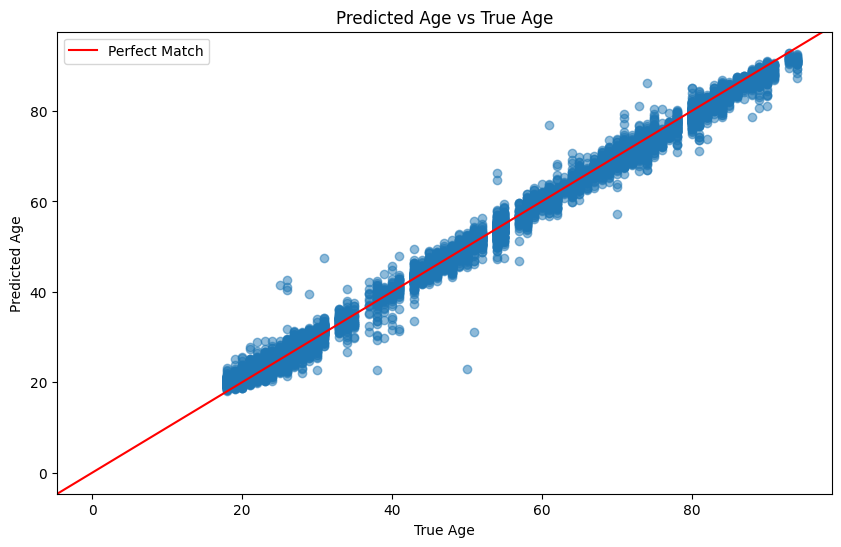

In [58]:
plot_scatter(true_labels, predictions)

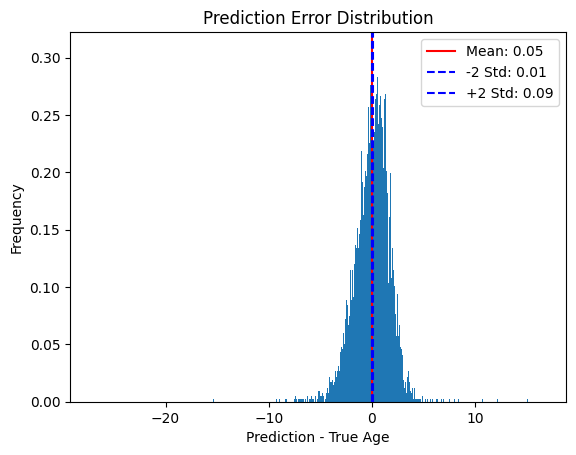

In [70]:
plot_error_distribution(true_labels, predictions)

In [ ]:
model = setup_model()
model.load_state_dict(torch.load('effnetb0_alz_ep19.pth', weights_only=True))

In [39]:
vmd_true_labels, vmd_predictions = evaluate(model, vmd_loader)

Mean Absolute Error (MAE): 8.158047676086426
Mean Squared Error (MSE): 141.35110473632812
Root Mean Squared Error (RMSE): 11.889117071352613
R2 Score: -1.8705503940582275


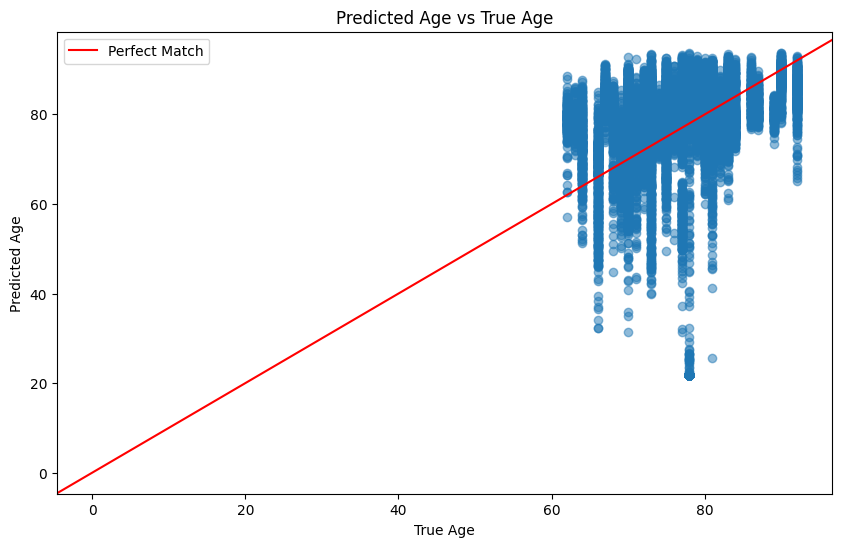

In [40]:
plot_scatter(vmd_true_labels, vmd_predictions)

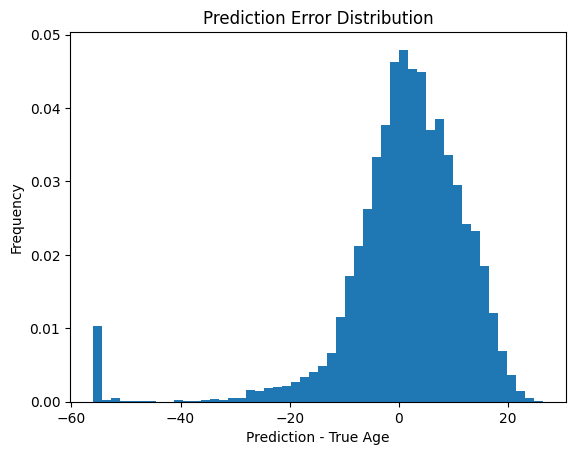

In [41]:
plot_error_distribution(vmd_true_labels, vmd_predictions)

Mean Absolute Error (MAE): 7.3041839599609375
Mean Squared Error (MSE): 82.9599380493164
Root Mean Squared Error (RMSE): 9.108234628582885
R2 Score: -0.6683971881866455


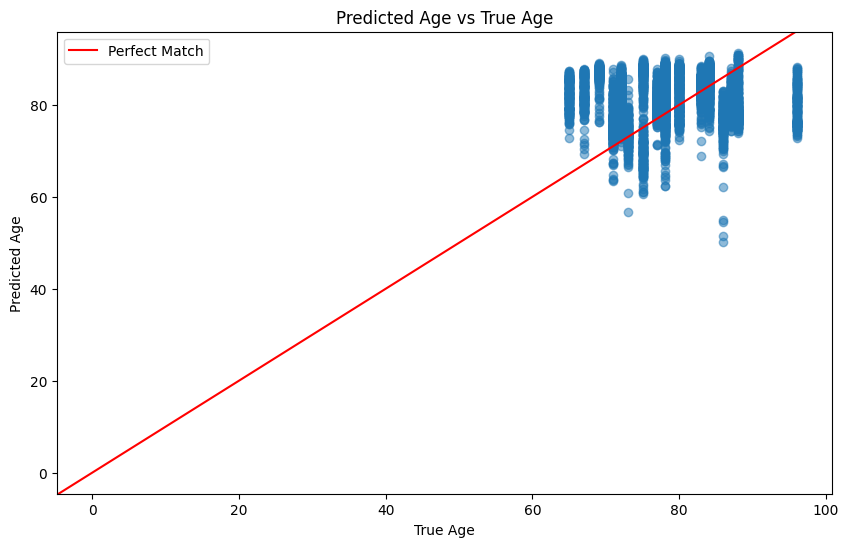

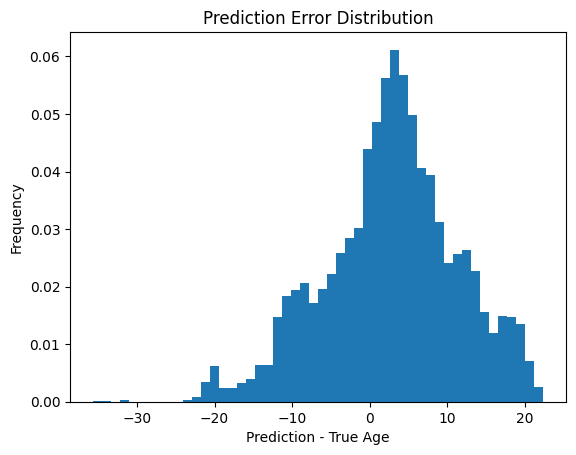

In [43]:
model = setup_model()
model.load_state_dict(torch.load('effnetb0_alz_ep19.pth', weights_only=True))
md_true_labels, md_predictions = evaluate(model, md_loader)

plot_error_distribution(md_true_labels, md_predictions)

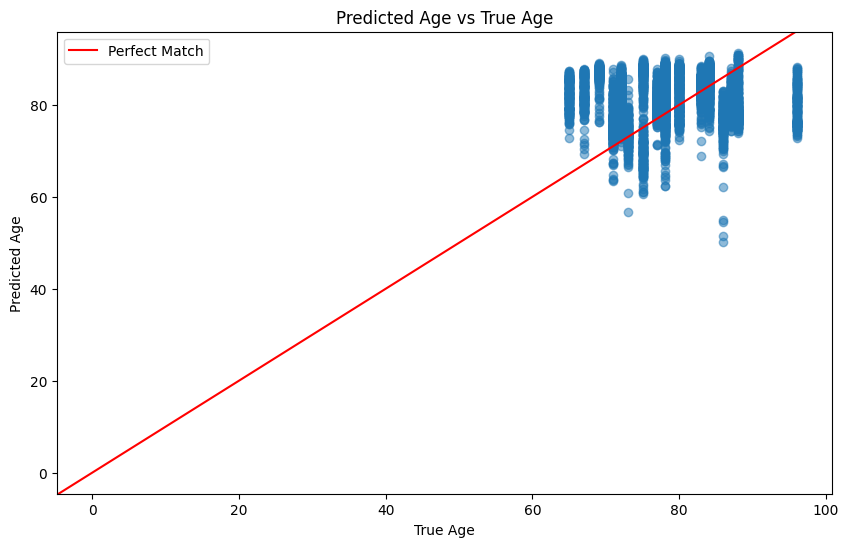

In [44]:
plot_scatter(md_true_labels, md_predictions)

In [12]:
###### INTERPRETABILITY ######

def prep_img(img_path):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((224, 224)),

        #significant transformations to force the model away from positional features
        #transforms.RandomApply([transforms.RandomRotation([90, 90])], p=1.0),
        #transforms.RandomApply([transforms.RandomRotation([180, 180])], p=0.25),
        #transforms.RandomApply([transforms.RandomRotation([270, 270])], p=1.0),
        #transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomVerticalFlip(p=0.5),
        
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    image = Image.open(img_path).convert('L')
    image = transform(image).unsqueeze(0) # unsqueeze(0) for batch dim
    return image

def pred_img(model, img_tensor):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else 
                         "mps" if torch.backends.mps.is_available() else
                         "cpu")
    model.to(device)
    img_tensor = img_tensor.to(device)
    return model(img_tensor)

In [13]:
### grad-cam pipeline ###
def run_grad_cam(model, image_path):
    gradients = None
    activations = None
    
    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output
        print('bhook')
    
    def forward_hook(module, args, output):
        nonlocal activations
        activations = output
        print('fhook')
    
    # target_layer = model.features[8][0] (?)
    backward_hook = model.features[8][0].register_full_backward_hook(backward_hook, prepend=False)
    forward_hook = model.features[8][0].register_forward_hook(forward_hook, prepend=False)

    # preprocess image
    image = prep_img(image_path)

    output = pred_img(model, image)
    print(f'prediction: {output.item()}')
    output.backward()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients[0], dim=[0,2,3])
    
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze() # average channels
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap) # normalize
    # uncomment to show raw heatmap
    #plt.matshow(heatmap.detach())

    # remove hooks
    backward_hook.remove()
    forward_hook.remove()
    
    # setup
    fig, ax = plt.subplots()
    ax.axis('off')
    
    # original image
    ax.imshow(to_pil_image(image.squeeze(1), mode='L'), cmap='gray')
    
    # heatmap
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((224,224), resample=PIL.Image.BICUBIC)
    
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    
    # plot heatmap on same axis
    ax.imshow(overlay, alpha=0.35, interpolation='nearest', extent=[0, 224, 224, 0])
    
    plt.show()

fhook
prediction: 60.974971771240234
bhook


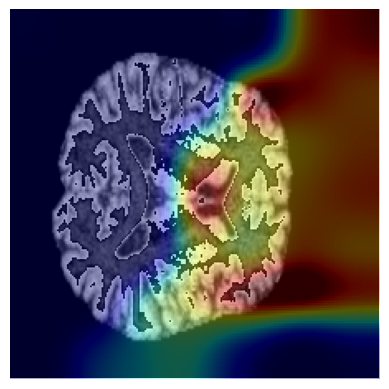

In [19]:
model = setup_model()
model.load_state_dict(torch.load('effnetb0_alz_ep19.pth', weights_only=True))
image_path = '/Users/adrianlayer/BGGN240/Final Project/alzheimers_dataset/split_data/test/OAS1_0457_MR1_2.nii_slice_133.png'
run_grad_cam(model, image_path)

- Disturbing revelation - on the third image path below, if you set the hooks to features[4] (or 5), you can see that the model is picking up on the subtle, barely perceptible artifacting present in the image. I worry that it learned to detect which images were coming from which patient based off the presence of these artifacts. In my preliminary examination of the data I have not managed to find a pattern suggesting as much, but I am not a machine learning model, so we need to be sure.

- Additional observation - when rotated 90 degrees, the model seems to not focus on the artifacts in some images.

## Scans that, when rotated 90 deg, show attention on the brain itself

### TEST
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/test/27_BRAIN_FLAIR_longTR_020_copy001.png'
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/test/76_Pha_Images_033.png'
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/test/27_BRAIN_FLAIR_longTR_021.png'
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/test/41_Ax_DWI_076.png'
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/test/41_Sag_CUBE_T2_131.png'
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/train/27_BRAIN_FLAIR_longTR_005.png'

### TRAIN
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/train/27_BRAIN_T1W_SE_COR+C_020.png'
* '/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/train/27_BRAIN_FLAIR_longTR_005.png'

**'/Users/adrianlayer/BGGN240/Final Project/split_data/PD Patients/train/49_t2_fl2d_ax_hemo_012.png'**